# Importing Necessary Libraries

In [77]:
import tensorflow as tf
import keras 
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array

In [78]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
color_img = []
path = '../input/landscape-image-colorization/landscape Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
        if i == '3664.jpg':
            break
        else:    
            img = cv2.imread(path + '/'+i,1)
            # open cv reads images in BGR format so we have to convert it to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = img.astype('float32') / 255.0
            color_img.append(img_to_array(img))


gray_img = []
path = '../input/landscape-image-colorization/landscape Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
         if i == '3664.jpg':
            break
         else: 
            img = cv2.imread(path + '/'+i,1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = img.astype('float32') / 255.0
            gray_img.append(img_to_array(img))

 51%|█████▏    | 3664/7129 [00:08<00:08, 407.58it/s]


# Creating Datasets


In [79]:
color_dataset=tf.data.Dataset.from_tensor_slices(np.array(color_img[:3300])).batch(64)
gray_dataset=tf.data.Dataset.from_tensor_slices(np.array(gray_img[:3300])).batch(64)

color_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(color_img[3300:])).batch(8)
gray_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(gray_img[3300:])).batch(8)

In [80]:
example_color = next(iter(color_dataset))
example_gray = next(iter(gray_dataset))

In [81]:
def plot_images(a = 4):
    
    for i in range(a):
        plt.figure(figsize = (10,10))
        plt.subplot(121)
        plt.title('color')
        plt.imshow(example_color[i] )

        plt.subplot(122)
        plt.title('gray')
        plt.imshow(example_gray[i])
        plt.show()

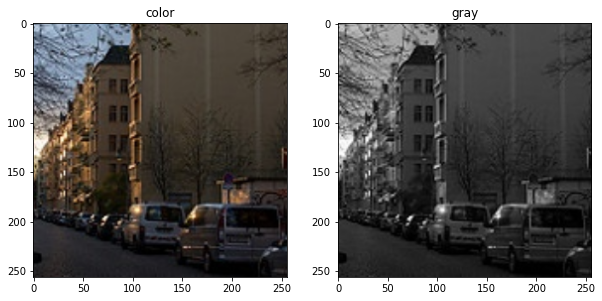

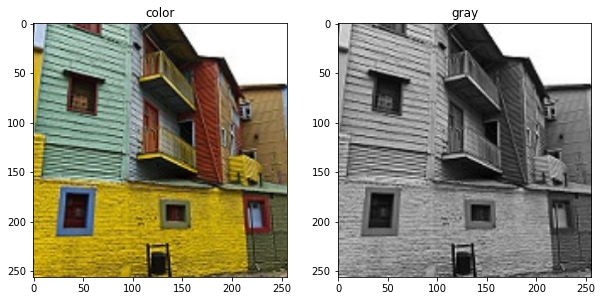

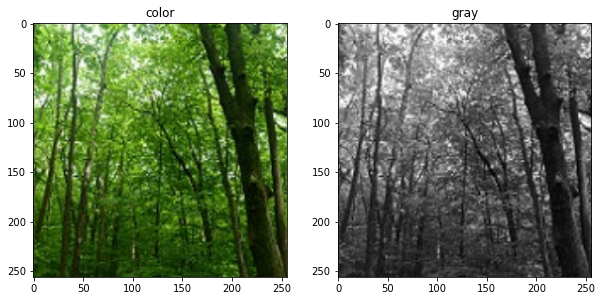

In [82]:
plot_images(3)

# Define downsample and upsample functions

In [83]:
def downsample(filters, size, apply_batchnorm=True):
  
  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer='he_normal', use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer='he_normal',
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result  

# Generator model

In [84]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


# Discriminator model

In [85]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [86]:
generator = Generator()
generator.summary()


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_54 (Sequential)      (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
sequential_55 (Sequential)      (None, 64, 64, 128)  131584      sequential_54[0][0]              
__________________________________________________________________________________________________
sequential_56 (Sequential)      (None, 32, 32, 256)  525312      sequential_55[0][0]              
____________________________________________________________________________________________

Initialize models

In [87]:
discriminator = Discriminator()
discriminator.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_31 (Concatenate)    (None, 256, 256, 6)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_69 (Sequential)      (None, 128, 128, 64) 6144        concatenate_31[0][0]       

# Loss functions and optimizers

In [88]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

# Training step

In [89]:
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

 

# Training function

In [90]:
import time
def fit(train_ds, epochs,):
  for epoch in range(epochs):
    start = time.time()

    print("Epoch: ", epoch+1)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      
      train_step(input_image, target, epoch)
    print()

  

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  


# Visualization function

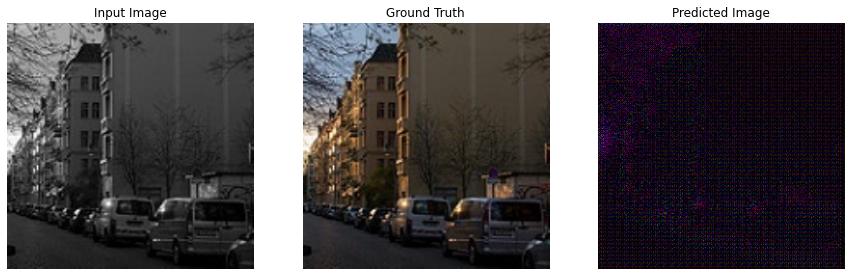

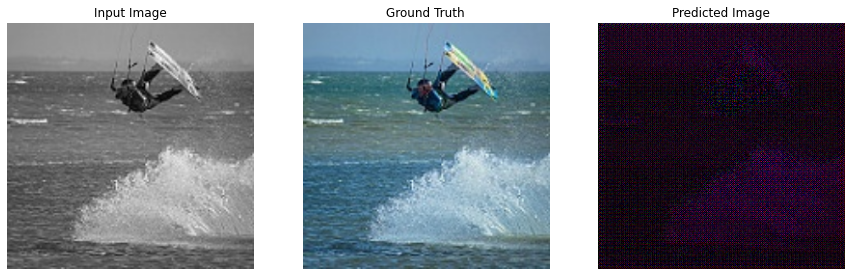

In [91]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

for example_input, example_target in tf.data.Dataset.zip((gray_dataset,color_dataset)).take(2):
  generate_images(generator, example_input, example_target)


# Training the model

In [92]:
fit(tf.data.Dataset.zip((gray_dataset, color_dataset)), epochs=30)

Epoch:  1

Time taken for epoch 1 is 169.41162252426147 sec

Epoch:  2

Time taken for epoch 2 is 164.81145763397217 sec

Epoch:  3

Time taken for epoch 3 is 164.9210512638092 sec

Epoch:  4

Time taken for epoch 4 is 164.78471064567566 sec

Epoch:  5

Time taken for epoch 5 is 164.700190782547 sec

Epoch:  6

Time taken for epoch 6 is 164.50332736968994 sec

Epoch:  7

Time taken for epoch 7 is 164.90936994552612 sec

Epoch:  8

Time taken for epoch 8 is 164.60920119285583 sec

Epoch:  9

Time taken for epoch 9 is 164.67151737213135 sec

Epoch:  10

Time taken for epoch 10 is 164.83410382270813 sec

Epoch:  11

Time taken for epoch 11 is 164.71894574165344 sec

Epoch:  12

Time taken for epoch 12 is 165.05195450782776 sec

Epoch:  13

Time taken for epoch 13 is 164.7510952949524 sec

Epoch:  14

Time taken for epoch 14 is 164.69972252845764 sec

Epoch:  15

Time taken for epoch 15 is 164.42015719413757 sec

Epoch:  16

Time taken for epoch 16 is 164.68922924995422 sec

Epoch:  17

Ti

# Save the trained generator model

In [97]:

generator.save('/kaggle/working/colorization_generator.h5')
print("Generator model saved to '/kaggle/working/colorization_generator.h5'")

Generator model saved to '/kaggle/working/colorization_generator.h5'


Visualization

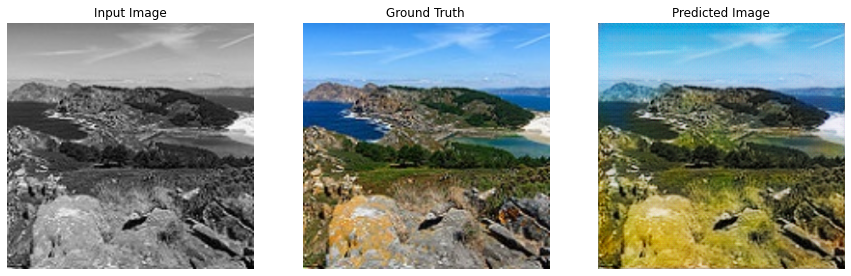

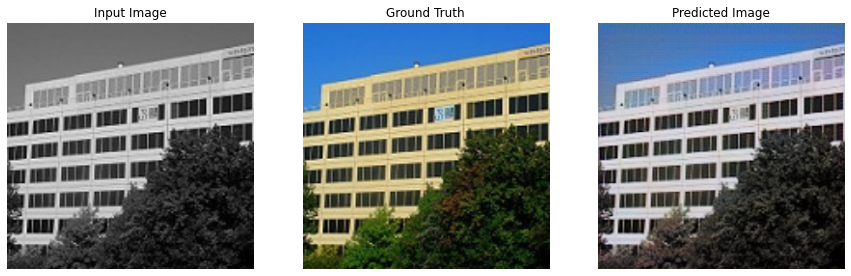

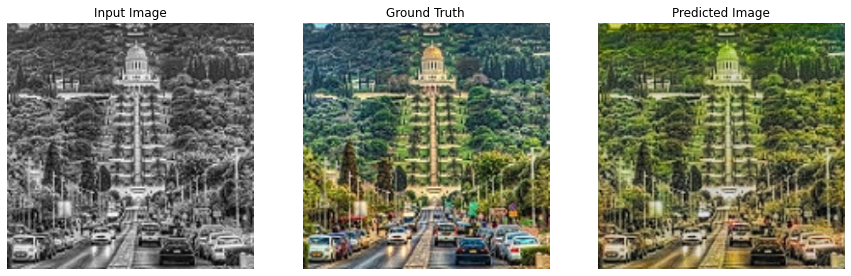

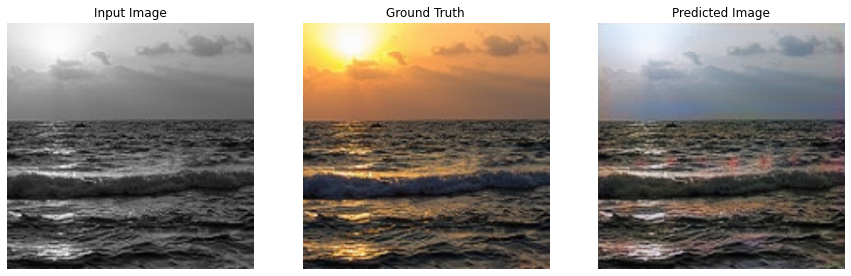

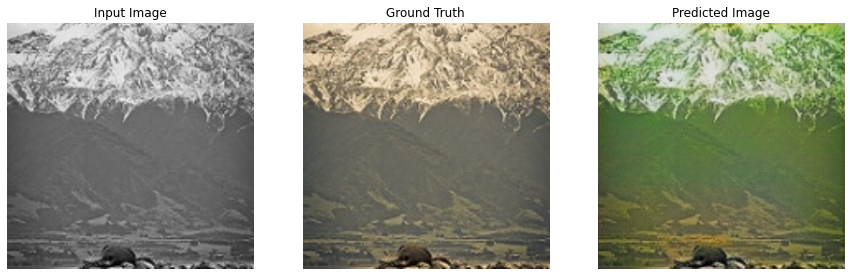

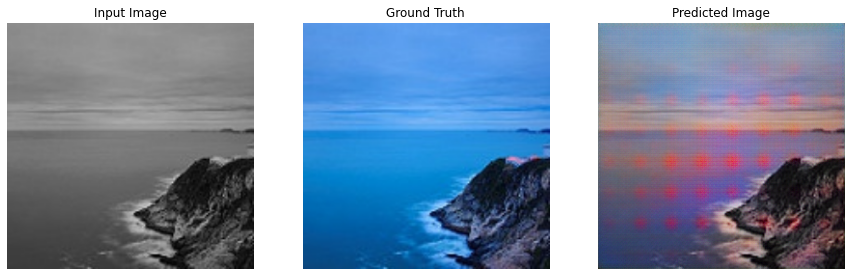

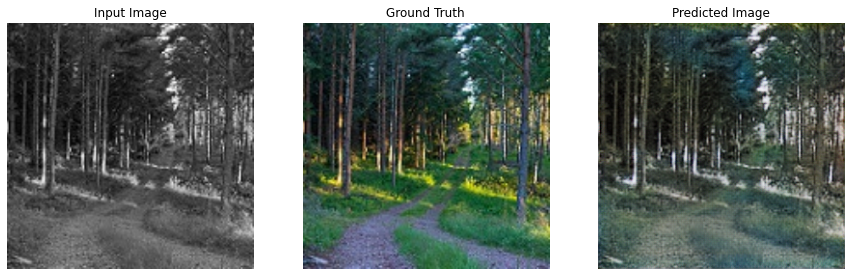

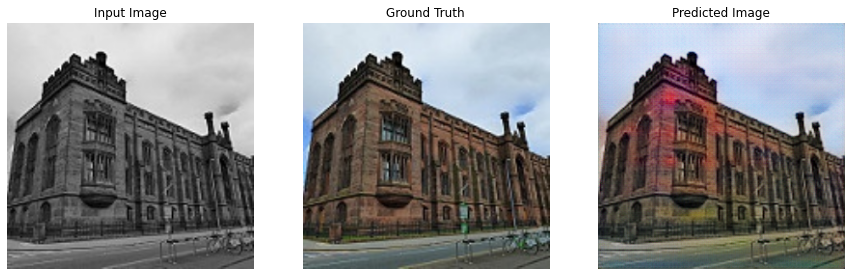

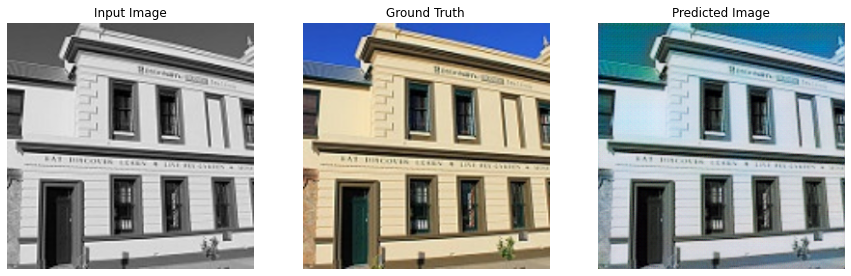

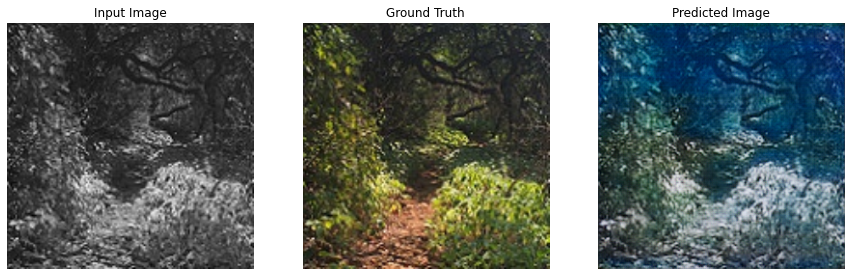

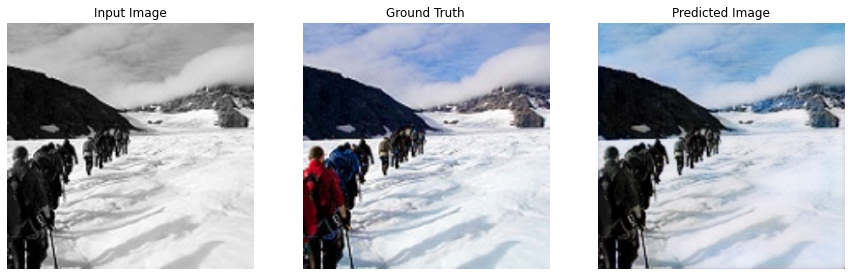

In [98]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

for example_input, example_target in tf.data.Dataset.zip((gray_dataset_t,color_dataset_t)).take(11):
  generate_images(generator, example_input, example_target)


# Image Colorization Using Model

In [100]:
# Load the saved generator model(if restaring the code)
generator = tf.keras.models.load_model('/kaggle/working/colorization_generator.h5')
print("Generator model loaded from '/kaggle/working/colorization_generator.h5'")

Generator model loaded from '/kaggle/working/colorization_generator.h5'


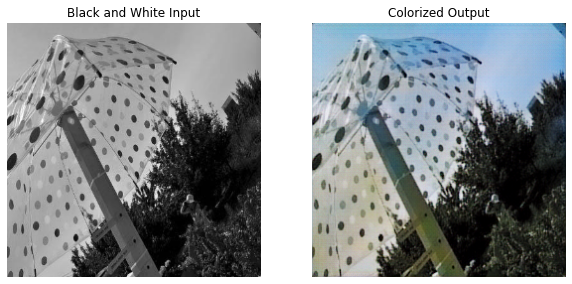

Colorized image saved to /kaggle/working/colorized_output.jpg


In [99]:
# New function to colorize a single black-and-white image in Kaggle
def colorize_new_image(image_path='/kaggle/input/test11/image5012.jpg'):
    # Read and preprocess the image
    img = cv2.imread(image_path, 1)
    if img is None:
        raise ValueError(f"Could not load image at {image_path}. Please check the path.")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    img_array = img_to_array(img)
    img_reshaped = tf.expand_dims(img_array, 0)  # Add batch dimension (1, 256, 256, 3)
    
    # Use the trained generator to colorize
    prediction = generator(img_reshaped, training=False)  # Inference mode
    
    # Display input and prediction side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Black and White Input')
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('Colorized Output')
    plt.imshow(prediction[0])  # Extract the single image from the batch
    plt.axis('off')
    plt.show()
    
    # Save the result
    save_path = '/kaggle/working/colorized_output.jpg'
    result = (prediction[0].numpy() * 255).astype(np.uint8)  # Convert to 0-255 range
    result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    cv2.imwrite(save_path, result)
    print(f"Colorized image saved to {save_path}")
    
    return prediction[0]  # Return the colorized image

# Call the new function with your specific image path
colorized = colorize_new_image('/kaggle/input/test11/image5012.jpg')